#Machine Learning Project - Assignmnet 10
##Optimal Selection of the hyper-parameters associated with the classification on MNIST
###CAUCSE senior 20151145 Kim Jekyun

##Computing Area

###0. Preset

In [ ]:
## Import required libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
%matplotlib inline

###1. Data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [ ]:
data_path = './MNIST'

testing_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
training_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

###2. Model

In [ ]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out

In [ ]:
# Definition of hyper parameters
learning_rate_value = 0.03
batch_size = 128
epochs = 30

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

###3. Loss function

In [ ]:
criterion = nn.NLLLoss()

###4. Optimization

In [ ]:
# Dataloader & Optimizer
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)

classifier = classification()
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate_value)

In [ ]:
# Training - Gradient Descent
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    train_loss_tmp = 0
    train_acc_tmp = 0

    for data, target in training_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward
        output = classifier(data)
        loss = criterion(output, target)
        # Backword
        loss.backward()
        # Loss
        train_loss_tmp += loss
        # Update
        optimizer.step()
        # Accuracy
        result = output.data.max(1)[1]
        accuracy = result.eq(target.data).sum() / 10*batch_size
        train_acc_tmp += accuracy
    
    train_loss.append(train_loss_tmp / batch_size)
    train_acc.append(train_acc_tmp / batch_size)
    
    test_loss_tmp = 0
    test_acc_tmp = 0
    
    with torch.no_grad():
        for data, target in testing_loader:
            # Forward
            output = classifier(data)
            loss = criterion(output, target)
            # Loss
            test_loss_tmp += loss
            # Accuracy
            result = output.data.max(1)[1]
            accuracy = result.eq(target.data).sum() / 10*batch_size
            test_acc_tmp += accuracy
    
    test_loss.append(test_loss_tmp / batch_size)
    test_acc.append(test_acc_tmp / batch_size)

In [ ]:
#train_loss_32 = train_loss_tmp / batch_size
#test_loss_32 = test_loss_tmp / batch_size
#train_acc_32 = train_acc_tmp / batch_size
#test_acc_32 = test_acc_tmp / batch_size
#train_loss_64 = train_loss_tmp / batch_size
#test_loss_64 = test_loss_tmp / batch_size
#train_acc_64 = train_acc_tmp / batch_size
#test_acc_64 = test_acc_tmp / batch_size
train_loss_128 = train_loss_tmp / batch_size
test_loss_128 = test_loss_tmp / batch_size
train_acc_128 = train_acc_tmp / batch_size
test_acc_128 = test_acc_tmp / batch_size

In [ ]:
ind_loss = ['training loss', 'testing loss']
ind_acc = ['traininng accuracy', 'testing accuracy']
col = ['32', '64', '128']
con_loss = [[train_loss_32.item(),train_loss_64.item(),train_loss_128.item()], [test_loss_32.item(),test_loss_64.item(),test_loss_128.item()]]
con_acc = [[(train_acc_32/100).item(),(train_acc_64/100).item(),(train_acc_128/100).item()], [(test_acc_32/100).item(),(test_acc_64/100).item(),(test_acc_128/100).item()]]

---
##Result Area

###1. Plot the training and testing losses with a batch size of 32 [4pt]

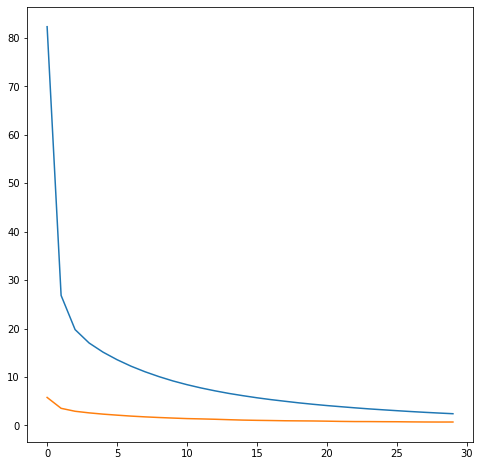

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

###2. Plot the training and testing accuracies with a batch size of 32 [4pt]

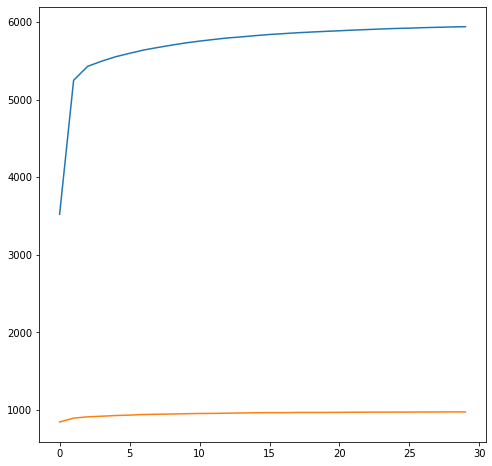

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

###3. Plot the training and testing losses with a batch size of 64 [4pt]

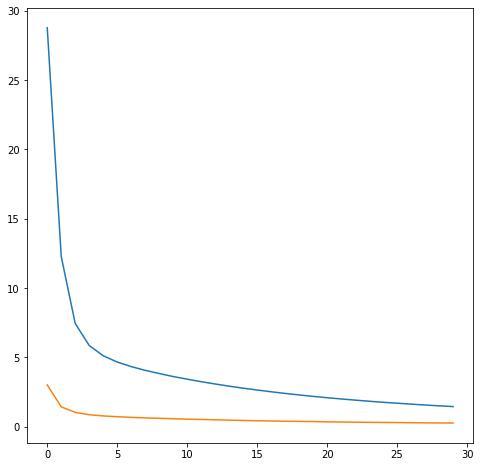

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

###4. Plot the training and testing accuracies with a batch size of 64 [4pt]

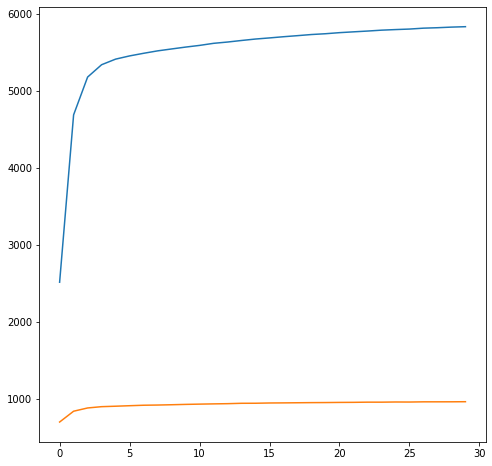

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

###5. Plot the training and testing losses with a batch size of 128 [4pt]

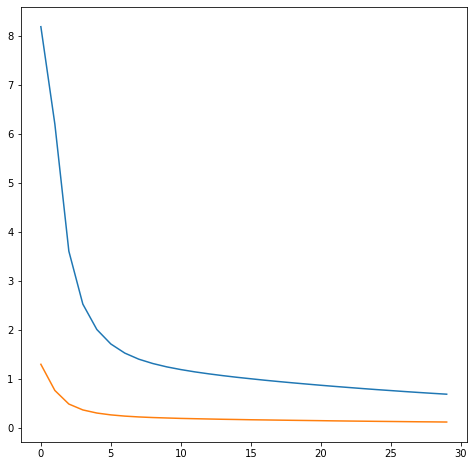

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

###6. Plot the training and testing accuracies with a batch size of 128 [4pt]

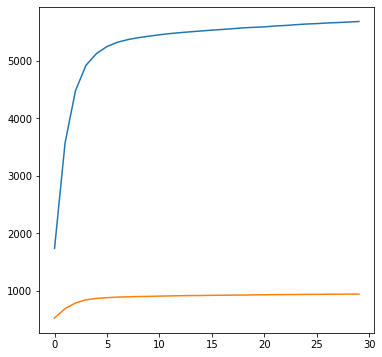

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_acc)
plt.plot(test_acc)
plt.show()

###7. Print the loss at convergence with different mini-batch sizes [3pt]

In [ ]:
pd.DataFrame(con_loss, columns=col, index=ind_loss)

,32,64,128
training loss,2.419568,1.459722,0.682588
testing loss,0.707441,0.274281,0.114711


###8. Print the accuracy at convergence with different mini-batch sizes [3pt]

In [ ]:
pd.DataFrame(con_acc, columns=col, index=ind_acc)

,32,64,128
traininng accuracy,59.384743,58.322002,56.79097
testing accuracy,9.770015,9.650004,9.46200
